# A simple demonstration of PySpark

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pyspark
import random
import time

## Estimate $\pi$

As a simple example, let's approximate $pi$ with brute force.

Define a function to decide whether a randomly chosen point in the $XY$ plane lies inside the unit circle.

In [2]:
def inside(p):     
    x, y = random.random(), random.random()
    return x*x + y*y < 1

Define a function that uses the `SparkContext`, `sc`, to distribute the work across partitions

In [3]:
def approx_pi(num_samples, num_partitions):
    num_inside = sc.parallelize(range(0, num_samples), num_partitions).filter(inside).count()
    pi = 4 * num_inside / num_samples
    return pi

Explore how the number of partitions affects the speed of the computation.

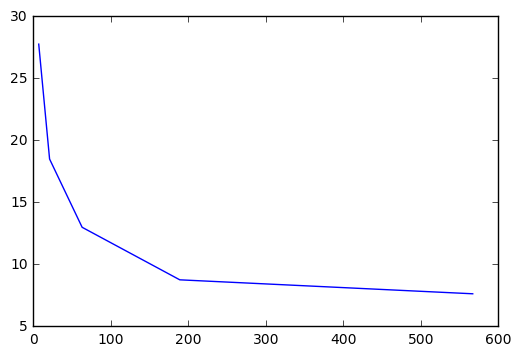

In [4]:
samples = 100000000
num_partitions = 7
errors = []
times = []
partitions = []

for _ in range(5):
    t0 = time.time()
    pi_approx = approx_pi(samples, num_partitions)
    t1 = time.time()
    
    
    dt = t1 - t0
    errors.append(pi_approx - 3.1415926536)
    times.append(dt)
    
    partitions.append(num_partitions)
    num_partitions *= 3
    

plt.plot(partitions, times)

# Test for Benford's law

Let's count the occurence of numeric digits within a body of text and decide if the distribution of digits follows [Benford's law](https://en.wikipedia.org/wiki/Benford%27s_law). The data we'll explore are bikeshare records in DC, currently available in the shared `/data` directory on the Big Data cluster. For example:

```bash
$ hadoop fs -cat /data/capitalbikeshare-data/2016-Q3-Trips-History-Data-1.csv | head -20
Duration (ms),Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member Type
840866,8/31/2016 23:59,9/1/2016 0:13,31117,15th & Euclid St  NW,31228,8th & H St NW,W20409,Registered
656098,8/31/2016 23:58,9/1/2016 0:09,31279,19th & G St NW,31600,5th & K St NW,W20756,Registered
353159,8/31/2016 23:58,9/1/2016 0:04,31107,Lamont & Mt Pleasant NW,31101,14th & V St NW,W22626,Registered
219234,8/31/2016 23:58,9/1/2016 0:02,31200,Massachusetts Ave & Dupont Circle NW,31212,21st & M St NW,W00980,Casual
213473,8/31/2016 23:56,8/31/2016 23:59,31281,8th & O St NW,31280,11th & S St NW,W21338,Registered
637695,8/31/2016 23:56,9/1/2016 0:07,31624,North Capitol St & F St NW,31241,Thomas Circle,W21422,Registered
356455,8/31/2016 23:54,9/1/2016 0:00,31034,N Randolph St & Fairfax Dr,31023,Fairfax Dr & Wilson Blvd,W00748,Casual
924793,8/31/2016 23:53,9/1/2016 0:08,31124,14th & Irving St NW,31267,17th St & Massachusetts Ave NW,W21480,Registered
309433,8/31/2016 23:53,8/31/2016 23:58,31242,18th St & Pennsylvania Ave NW,31285,22nd & P ST NW,W20113,Registered
447572,8/31/2016 23:52,8/31/2016 23:59,31007,Crystal City Metro / 18th & Bell St,31011,23rd & Crystal Dr,W00943,Registered
438823,8/31/2016 23:52,8/31/2016 23:59,31122,16th & Irving St NW,31214,17th & Corcoran St NW,W00833,Registered
350341,8/31/2016 23:51,8/31/2016 23:57,31264,6th St & Indiana Ave NW,31244,4th & E St SW,W20404,Registered
568722,8/31/2016 23:51,9/1/2016 0:01,31238,14th & G St NW,31201,15th & P St NW,W22750,Registered
229685,8/31/2016 23:50,8/31/2016 23:54,31304,36th & Calvert St NW / Glover Park,31226,34th St & Wisconsin Ave NW,W21185,Registered
405098,8/31/2016 23:50,8/31/2016 23:57,31212,21st & M St NW,31114,18th St & Wyoming Ave NW,W22401,Registered
2592652,8/31/2016 23:47,9/1/2016 0:30,31067,Columbia Pike & S Walter Reed Dr,31260,23rd & E St NW ,W21736,Registered
570531,8/31/2016 23:46,8/31/2016 23:56,31111,10th & U St NW,31122,16th & Irving St NW,W21005,Registered
981529,8/31/2016 23:46,9/1/2016 0:03,31235,19th St & Constitution Ave NW,31258,Lincoln Memorial,W22953,Registered
1138485,8/31/2016 23:45,9/1/2016 0:04,31000,Eads St & 15th St S,31000,Eads St & 15th St S,W21251,Casual
```

Define our mapping function that will count the number of digits

In [5]:
def count_digits(string):
    counter = [0] * 10
    for c in string:
        if c in '0123456789':
            counter[int(c)] += 1
    return counter

dummy_counter = count_digits('abcd111123234')
print(dummy_counter)

[0, 4, 2, 2, 1, 0, 0, 0, 0, 0]


Define a reduce function that combines two counters into one.

In [6]:
def combine_digits(a, b):
    # assert(len(a) == len(b) == 10)
    return [a[i] + b[i] for i in range(10)]

print(combine_digits(dummy_counter, dummy_counter))

[0, 8, 4, 4, 2, 0, 0, 0, 0, 0]


Apply the map and reduce functions

In [7]:
lines = sc.textFile('/data/capital*/*.csv', 60) # notice the globbing functionality in the file names
counts = lines.map(count_digits).reduce(combine_digits)
print(counts)

[89309440, 133682530, 96328002, 50280321, 38989407, 37620303, 30666030, 27789765, 26541711, 23779326]


Plot the counts as a histogram.

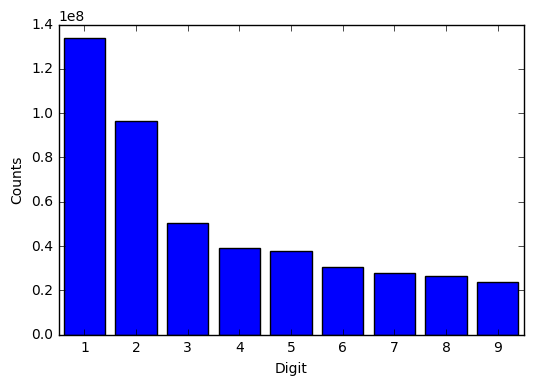

In [8]:
fig, ax = plt.subplots()
ax.bar(range(1,10), counts[1:], align='center')
ax.set_ylabel('Counts')
ax.set_xlabel('Digit')
ax.set_xlim(0.5, 9.5)
ax.set_xticks(range(1, 10))
# ax.set_xticklabels(range(1,10))

A set of numbers is said to satisfy Benford's law if the leading digit $d (d ∈ {1, ..., 9})$ occurs with probability

$$
    P ( d ) = \log _{10}\left(1+{\frac {1}{d}}\right). 
    $$

In [11]:
from math import log10

total_counts = sum(counts[1:])
probs = [cts / total_counts for cts in counts]

for d, prob in enumerate(probs):
    if d == 0:
        continue
    ideal = log10(1 + 1 / d)
    print("Ideal: {0} --- Actual {1}".format(ideal, prob))

Ideal: 0.3010299956639812 --- Actual 0.28707111711961025
Ideal: 0.17609125905568124 --- Actual 0.20685565379440418
Ideal: 0.12493873660829992 --- Actual 0.10797243228866628
Ideal: 0.09691001300805642 --- Actual 0.08372621780363636
Ideal: 0.07918124604762482 --- Actual 0.08078619104970727
Ideal: 0.06694678963061322 --- Actual 0.06585252006917794
Ideal: 0.05799194697768673 --- Actual 0.05967600166634672
Ideal: 0.05115252244738129 --- Actual 0.05699591881628697
Ideal: 0.04575749056067514 --- Actual 0.05106394739216406


sc.stop()